In [483]:
## на 2/01 - лучшее решение
## cb+lgb - итог 0.044480 - место 44
## submit 13 - хорошо зажег признак id

In [434]:
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [435]:
# magic command to display matplotlib plots inline within the ipython notebook
%matplotlib inline

# import necessary modules
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [436]:
import catboost as cb

In [437]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [438]:
X = pd.read_csv('X_without_nulls.csv')

In [439]:
X.head(2)

,Unnamed: 0,address,address_rus,atm_group,id,isTrain,lat,long,target
0,0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",32.0,8526.0,True,46.940995,142.738319,0.01150
1,1,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",32.0,8532.0,True,46.937353,142.753348,0.02971


# Количество банкоматов стоящих по одному адресу

In [440]:
counts = X.groupby(['lat','long'])['id'].count().reset_index().rename(columns={'id':'count'})
X = pd.merge(X, counts, how='left', on=['lat','long'])
X.head()

,Unnamed: 0,address,address_rus,atm_group,id,isTrain,lat,long,target,count
0,0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",32.0,8526.0,True,46.940995,142.738319,0.011500,1.0
1,1,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",32.0,8532.0,True,46.937353,142.753348,0.029710,1.0
2,2,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",32.0,8533.0,True,46.959413,142.741113,0.009540,1.0
3,3,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",32.0,8684.0,True,55.805827,37.515146,-0.094035,1.0
4,4,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",32.0,37.0,True,69.343541,88.211228,0.079277,1.0


# Город размещения

In [441]:
X['city'] = X[~X.address_rus.isnull()].address_rus.apply(lambda x: x.split(',')[2])
rare_cities = X.city.value_counts()[(X.city.value_counts() < 20) ==True].index
X.city = X.city.apply(lambda x: 'RARE' if x in rare_cities else x)
X.city= X.city.rank().fillna(-1)
X.head()

,Unnamed: 0,address,address_rus,atm_group,id,isTrain,lat,long,target,count,city
0,0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",32.0,8526.0,True,46.940995,142.738319,0.011500,1.0,5272.0
1,1,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",32.0,8532.0,True,46.937353,142.753348,0.029710,1.0,5272.0
2,2,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",32.0,8533.0,True,46.959413,142.741113,0.009540,1.0,6926.5
3,3,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",32.0,8684.0,True,55.805827,37.515146,-0.094035,1.0,2212.5
4,4,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",32.0,37.0,True,69.343541,88.211228,0.079277,1.0,3152.5


In [442]:
X.shape

(8765, 11)

# Расстояния до ближайших банкоматов

In [443]:
R = 6373.0 # радиус земли в километрах

def distance(x,y):
    """
    Параметры
    ----------
    x : tuple, широта и долгота первой геокоординаты 
    y : tuple, широта и долгота второй геокоординаты 
    
    Результат
    ----------
    result : дистанция в километрах между двумя геокоординатами
    """
    lat_a, long_a, lat_b, long_b = map(radians, [x[0],x[1],y[0],y[1]])    
    dlon = long_b - long_a
    dlat = lat_b - lat_a
    a = sin(dlat/2)**2 + cos(lat_a) * cos(lat_b) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [444]:
knc = KNeighborsClassifier(metric=distance)

In [445]:
dots = X[['lat','long']].dropna()

In [446]:
dots.head()

,lat,long
0,46.940995,142.738319
1,46.937353,142.753348
2,46.959413,142.741113
3,55.805827,37.515146
4,69.343541,88.211228


In [447]:
knc.fit(X=dots , y=np.ones(dots.shape[0]))

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function distance at 0x114795050>, metric_params=None,
           n_jobs=None, n_neighbors=5, p=2, weights='uniform')

In [448]:
distances, indexes = knc.kneighbors(X=dots,n_neighbors=6,)

In [449]:
for i in range(1,4):
    dots['distance_%s'%i] = distances[:,i]
    dots['indexes_%s'%i] = indexes[:,i]

In [450]:
dots['mean'] = dots.iloc[:,dots.columns.str.contains('distance')].mean(axis=1)

In [451]:
dots = dots.drop(columns = ['lat','long'])

In [452]:
X = pd.concat([X,dots], axis=1)

In [453]:
X.columns

Index([u'Unnamed: 0', u'address', u'address_rus', u'atm_group', u'id',
       u'isTrain', u'lat', u'long', u'target', u'count', u'city',
       u'distance_1', u'indexes_1', u'distance_2', u'indexes_2', u'distance_3',
       u'indexes_3', u'mean'],
      dtype='object')

In [454]:
X.head()

,Unnamed: 0,address,address_rus,atm_group,id,isTrain,lat,long,target,count,city,distance_1,indexes_1,distance_2,indexes_2,distance_3,indexes_3,mean
0,0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",32.0,8526.0,True,46.940995,142.738319,0.011500,1.0,5272.0,0.171318,8702.0,0.406053,6072.0,0.447444,3756.0,0.341605
1,1,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",32.0,8532.0,True,46.937353,142.753348,0.029710,1.0,5272.0,0.243277,1714.0,0.649501,434.0,0.720783,8287.0,0.537854
2,2,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",32.0,8533.0,True,46.959413,142.741113,0.009540,1.0,6926.5,0.063770,3021.0,0.221691,4230.0,0.221691,2516.0,0.169050
3,3,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",32.0,8684.0,True,55.805827,37.515146,-0.094035,1.0,2212.5,0.371956,6485.0,0.642700,7886.0,0.701862,7200.0,0.572172
4,4,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",32.0,37.0,True,69.343541,88.211228,0.079277,1.0,3152.5,0.199516,4801.0,0.367687,3593.0,0.394887,3565.0,0.320697


# Количество банкоматов одного провайдера в городе

In [455]:
atm_city = pd.DataFrame(X.groupby('city')['atm_group'].value_counts()).rename(columns={'atm_group':'atm_city'}).reset_index()

In [456]:
X = pd.merge(X,atm_city,how='left',left_on=['city','atm_group'],right_on=['city','atm_group'])

# Численность населения города

In [457]:
X['city_name'] = X[~X.address_rus.isnull()].address_rus.apply(lambda x: x.split(',')[2])
cities = pd.read_excel('city2.xlsx')
cities.city_name = cities.city_name.apply(lambda x: x.encode('utf-8'))
X = pd.merge(X, cities, how='left', on='city_name')

In [458]:
X.isnull().sum()

Unnamed: 0        0
address           0
address_rus     420
atm_group         0
id                0
isTrain           0
lat               0
long              1
target         2504
count             1
city              0
distance_1        1
indexes_1         1
distance_2        1
indexes_2         1
distance_3        1
indexes_3         1
mean              1
atm_city          0
city_name       420
№              2781
population     2781
dtype: int64

In [459]:
X.population = X.population.apply(lambda x: str(x).replace(' ', '')).replace('nan', 0).astype(int)
X.head()

,Unnamed: 0,address,address_rus,atm_group,id,isTrain,lat,long,target,count,...,indexes_1,distance_2,indexes_2,distance_3,indexes_3,mean,atm_city,city_name,№,population
0,0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",32.0,8526.0,True,46.940995,142.738319,0.011500,1.0,...,8702.0,0.406053,6072.0,0.447444,3756.0,0.341605,6,Южно-Сахалинск,168.0,194882
1,1,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",32.0,8532.0,True,46.937353,142.753348,0.029710,1.0,...,1714.0,0.649501,434.0,0.720783,8287.0,0.537854,6,Южно-Сахалинск,168.0,194882
2,2,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",32.0,8533.0,True,46.959413,142.741113,0.009540,1.0,...,3021.0,0.221691,4230.0,0.221691,2516.0,0.169050,5,Сахалинская область,NaN,0
3,3,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",32.0,8684.0,True,55.805827,37.515146,-0.094035,1.0,...,6485.0,0.642700,7886.0,0.701862,7200.0,0.572172,19,Москва,75.0,12380664
4,4,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",32.0,37.0,True,69.343541,88.211228,0.079277,1.0,...,4801.0,0.367687,3593.0,0.394887,3565.0,0.320697,5,Норильск,100.0,178018


# Model

In [460]:
X.long = X.long.fillna(0)
X.atm_group = X.atm_group.astype(int)

In [334]:
X.lat, X.long = X.lat.astype(int), X.long.astype(int)

In [461]:
X_ = X[X.isTrain][['atm_group', 'lat', 'long',  'count', 'distance_1',
                    'distance_2',  'distance_3',   'mean', 'population','id']]
Y_ = X.loc[X.isTrain, 'target']

X_test = X[~X.isTrain][['atm_group', 'lat', 'long',  'count', 'distance_1',
                    'distance_2',  'distance_3',   'mean', 'population','id']]

In [462]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_, Y_, test_size=0.25, random_state=1)

In [487]:
X_.head()

,atm_group,lat,long,count,distance_1,distance_2,distance_3,mean,population,id
0,32,46.940995,142.738319,1.0,0.171318,0.406053,0.447444,0.341605,194882,8526.0
1,32,46.937353,142.753348,1.0,0.243277,0.649501,0.720783,0.537854,194882,8532.0
2,32,46.959413,142.741113,1.0,0.063770,0.221691,0.221691,0.169050,0,8533.0
3,32,55.805827,37.515146,1.0,0.371956,0.642700,0.701862,0.572172,12380664,8684.0
4,32,69.343541,88.211228,1.0,0.199516,0.367687,0.394887,0.320697,178018,37.0


## catboost

In [464]:
categorical = ['atm_group']

In [465]:
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]
categorical_features_pos = column_index(X_train,categorical)

In [466]:
categorical_features_pos

array([0])

In [467]:
cb_model = cb.CatBoostRegressor(iterations=1000,
                             learning_rate=0.02,
                             depth=12,
                             one_hot_max_size=10,
                             eval_metric='RMSE',
                             random_seed = 23,
                             cat_features = categorical_features_pos ,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100,)

In [342]:
cb_model.fit(X_train, Y_train,
             eval_set=(X_valid,Y_valid),
             use_best_model=True)

0:	learn: 0.0851189	test: 0.0835638	best: 0.0835638 (0)	total: 977ms	remaining: 16m 16s
75:	learn: 0.0497264	test: 0.0501588	best: 0.0501588 (75)	total: 31.8s	remaining: 6m 26s
150:	learn: 0.0455153	test: 0.0467061	best: 0.0467061 (150)	total: 1m 2s	remaining: 5m 50s
225:	learn: 0.0441515	test: 0.0459806	best: 0.0459806 (225)	total: 1m 28s	remaining: 5m 2s
300:	learn: 0.0431778	test: 0.0456592	best: 0.0456588 (299)	total: 1m 52s	remaining: 4m 22s
375:	learn: 0.0424419	test: 0.0453871	best: 0.0453870 (374)	total: 2m 14s	remaining: 3m 43s
450:	learn: 0.0419669	test: 0.0452708	best: 0.0452708 (449)	total: 2m 30s	remaining: 3m 3s
525:	learn: 0.0415405	test: 0.0451306	best: 0.0451306 (525)	total: 2m 49s	remaining: 2m 32s
600:	learn: 0.0411624	test: 0.0450197	best: 0.0450197 (600)	total: 3m 8s	remaining: 2m 5s
675:	learn: 0.0407332	test: 0.0448589	best: 0.0448586 (670)	total: 3m 32s	remaining: 1m 42s
750:	learn: 0.0403613	test: 0.0447074	best: 0.0447074 (750)	total: 4m 3s	remaining: 1m 20s
8

In [468]:
cb_model.fit(X_train, Y_train,
             eval_set=(X_valid,Y_valid),
             use_best_model=True)

0:	learn: 0.0851176	test: 0.0835638	best: 0.0835638 (0)	total: 1.7s	remaining: 28m 22s
75:	learn: 0.0492929	test: 0.0500759	best: 0.0500759 (75)	total: 35.7s	remaining: 7m 14s
150:	learn: 0.0447235	test: 0.0463864	best: 0.0463864 (150)	total: 1m 4s	remaining: 6m 5s
225:	learn: 0.0434448	test: 0.0457675	best: 0.0457675 (225)	total: 1m 27s	remaining: 4m 59s
300:	learn: 0.0425734	test: 0.0454501	best: 0.0454501 (300)	total: 1m 48s	remaining: 4m 12s
375:	learn: 0.0418791	test: 0.0452377	best: 0.0452377 (375)	total: 2m 11s	remaining: 3m 37s
450:	learn: 0.0414281	test: 0.0451395	best: 0.0451395 (449)	total: 2m 27s	remaining: 3m
525:	learn: 0.0410701	test: 0.0450202	best: 0.0450195 (522)	total: 2m 42s	remaining: 2m 26s
600:	learn: 0.0406598	test: 0.0448777	best: 0.0448766 (595)	total: 3m	remaining: 1m 59s
675:	learn: 0.0403267	test: 0.0448255	best: 0.0448184 (654)	total: 3m 25s	remaining: 1m 38s
750:	learn: 0.0399797	test: 0.0447520	best: 0.0447517 (749)	total: 3m 53s	remaining: 1m 17s
825:	l

In [343]:
#iterations 1000
rmse(Y_valid, cb_model.predict(X_valid)) 

0.04457866618444752

In [470]:
#iterations 1000
rmse(Y_valid, cb_model.predict(X_valid)) 

0.044518625039259914

In [471]:
submit_cb = pd.DataFrame(cb_model.predict(X_test), index=test.index,columns=['target'])

In [480]:
#submit_cb.to_csv('submit_12.csv') - переобучен скор на паблике = 0.044828

In [296]:
feature_score = pd.DataFrame(list(zip(X_.dtypes.index, cb_model.get_feature_importance(cb.Pool(X_, label=Y_)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

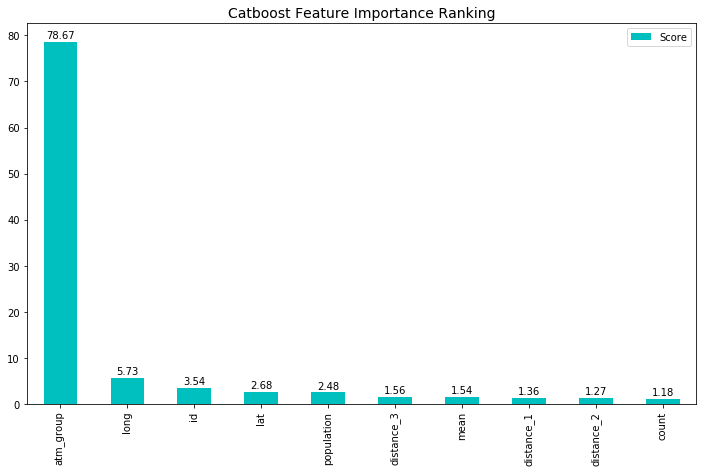

In [297]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

## LightGBM

In [473]:
import lightgbm as lgb
from sklearn import metrics

In [474]:
lgb_model = lgb.LGBMRegressor(objective = 'regression',  
                             max_depth = 10,
                             colsample_bytre = 0.8,
                             subsample = 0.8, 
                             learning_rate = 0.01,
                             n_estimators = 1000)

In [363]:
#param_dist = {"max_depth": [10, 25,50, 75],
#              "learning_rate" : [0.01,0.05,0.1],
#              "num_leaves": [300,900,1200],
#              "n_estimators": [500,1000],
#              "colsample_bytre" : [0.8],
#               "subsample" : [0.8], 
#             }

In [364]:
#lg = lgb.LGBMRegressor(silent=False)
#grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="neg_mean_squared_error", verbose=5)
#grid_search.fit(X_train,Y_train)
#grid_search.best_estimator_

In [365]:
#grid_search.best_estimator_

In [475]:
lgb_model.fit(X_train,Y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytre=0.8,
       colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
       max_depth=10, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=31,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=0.8,
       subsample_for_bin=200000, subsample_freq=0)

In [367]:
#rmse(Y_valid, grid_search.predict(X_valid))

In [368]:
rmse(Y_valid, lgb_model.predict(X_valid))

0.044913827247448745

In [476]:
rmse(Y_valid, lgb_model.predict(X_valid))

0.04441808713676163

In [353]:
rmse(Y_valid, cb_model.predict(X_valid))

0.04457866618444752

In [477]:
submit_lgb = pd.DataFrame(lgb_model.predict(X_test), index=test.index,columns=['target'])

In [478]:
submit = 0.6*submit_cb + 0.4*submit_lgb

In [482]:
submit.to_csv('submit_13.csv') #!!!!!! - скор на паблике 0.044480 - место 44